# Лабораторная работа №1

### Разведочный анализ данных с помощью PySpark

### Цели и задачи:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных;
3. Получить навыки выполнения разведочного анализа данных использованием pyspark.


# Ход работы

In [4]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

# Обзор датасета

In [5]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
# Укажите путь к CSV файлу
csv_file_path = "itineraries.csv"

# Прочитайте CSV файл в DataFrame
df = spark.read.csv(csv_file_path, header=True, sep=',', inferSchema=True)

drop_columns = ['legId', 'searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'segmentsCabinCode', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds',
                'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription',
               'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode']

df = df.select([col for col in df.columns if col not in drop_columns])

limited_data_pandas = df.limit(10)

limited_data_pandas.toPandas()

,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance
0,PT2H29M,0,False,False,True,217.67,248.6,9,947
1,PT2H30M,0,False,False,True,217.67,248.6,4,947
2,PT2H30M,0,False,False,True,217.67,248.6,9,947
3,PT2H32M,0,False,False,True,217.67,248.6,8,947
4,PT2H34M,0,False,False,True,217.67,248.6,9,947
5,PT2H38M,0,False,False,True,217.67,248.6,7,947
6,PT4H12M,0,False,False,False,213.02,251.1,3,956
7,PT5H18M,0,False,False,False,213.02,251.1,3,956
8,PT5H32M,0,False,False,False,213.02,251.1,7,956
9,PT6H38M,0,False,False,False,213.02,251.1,7,956


# Определение типов данных колонок

In [6]:
data_types_df = pd.DataFrame(df.dtypes, columns=['Column Name', 'Data type'])

# Добавление колонки с типами признаков данных
data_types = []
for col in data_types_df['Data type']:
    if 'timestamp' in col.lower():
        data_types.append('Временной')
    elif 'int' in col.lower() or 'double' in col.lower() or 'float' in col.lower():
        data_types.append('Числовой')
    elif 'string' in col.lower():
        data_types.append('Строковый')
    elif 'boolean' in col.lower():
        data_types.append('Булевый')
    else:
        data_types.append('Неопределенный')

data_types_df['Feature Type'] = data_types

# Вывод типов признаков
print('Columns overview')
print(data_types_df)

Columns overview
           Column Name Data type Feature Type
0       travelDuration    string    Строковый
1          elapsedDays       int     Числовой
2       isBasicEconomy   boolean      Булевый
3         isRefundable   boolean      Булевый
4            isNonStop   boolean      Булевый
5             baseFare    double     Числовой
6            totalFare    double     Числовой
7       seatsRemaining       int     Числовой
8  totalTravelDistance       int     Числовой


# Преобразование длительности полета в числовое значение (минуты полета)

In [7]:
from pyspark.sql.functions import col, regexp_extract
# Функция для преобразования формата "PT2H29M" в минуты и записи в новую колонку
def convert_duration_to_minutes(df, column):
    # Извлекаем часы и минуты из строки
    hours = regexp_extract(col(column), r'PT(\d+)H', 1).cast('int')
    minutes = regexp_extract(col(column), r'(\d+)M', 1).cast('int')
    
    # Выполняем необходимые вычисления
    minutes_in_total = hours * 60 + minutes
    
    # Добавляем новую колонку
    df = df.withColumn(f"{column}_inMinutes", minutes_in_total)
    
    return df

# Применяем функцию для указанной колонки "travelDuration"
df = convert_duration_to_minutes(df, "travelDuration")

df = df.drop("travelDuration")

# Печатаем DataFrame с новой колонкой
limited_data_pandas = df.limit(10)

limited_data_pandas.toPandas()

,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration_inMinutes
0,0,False,False,True,217.67,248.6,9,947,149
1,0,False,False,True,217.67,248.6,4,947,150
2,0,False,False,True,217.67,248.6,9,947,150
3,0,False,False,True,217.67,248.6,8,947,152
4,0,False,False,True,217.67,248.6,9,947,154
5,0,False,False,True,217.67,248.6,7,947,158
6,0,False,False,False,213.02,251.1,3,956,252
7,0,False,False,False,213.02,251.1,3,956,318
8,0,False,False,False,213.02,251.1,7,956,332
9,0,False,False,False,213.02,251.1,7,956,398


# Преобразование elapsedDays в булевый тип

In [8]:
from pyspark.sql.functions import col, when
# Преобразование колонки elapsedDays в булевый тип
df_transformed = df.withColumn(
    "elapsedDays_bool",
    when(col("elapsedDays") == 0, False).otherwise(True)
)

df = df_transformed
df = df.drop("elapsedDays")

# Печатаем DataFrame с новой колонкой
limited_data_pandas = df.limit(10)

limited_data_pandas.toPandas()

,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration_inMinutes,elapsedDays_bool
0,False,False,True,217.67,248.6,9,947,149,False
1,False,False,True,217.67,248.6,4,947,150,False
2,False,False,True,217.67,248.6,9,947,150,False
3,False,False,True,217.67,248.6,8,947,152,False
4,False,False,True,217.67,248.6,9,947,154,False
5,False,False,True,217.67,248.6,7,947,158,False
6,False,False,False,213.02,251.1,3,956,252,False
7,False,False,False,213.02,251.1,3,956,318,False
8,False,False,False,213.02,251.1,7,956,332,False
9,False,False,False,213.02,251.1,7,956,398,False


# Поиск и удаление пустых значений

In [9]:
for col_name in df.columns:
    count_missing = df.filter(col(col_name).isNull()).count()
    print(f"Количество пустых значений в колонке '{col_name}': {count_missing}")


Количество пустых значений в колонке 'isBasicEconomy': 1
Количество пустых значений в колонке 'isRefundable': 1
Количество пустых значений в колонке 'isNonStop': 1
Количество пустых значений в колонке 'baseFare': 1
Количество пустых значений в колонке 'totalFare': 1
Количество пустых значений в колонке 'seatsRemaining': 1
Количество пустых значений в колонке 'totalTravelDistance': 1004282
Количество пустых значений в колонке 'travelDuration_inMinutes': 307814
Количество пустых значений в колонке 'elapsedDays_bool': 0


In [10]:
# Удаляем строки с пустыми значениями
df = df.na.drop()

for col_name in df.columns:
    count_missing = df.filter(col(col_name).isNull()).count()
    print(f"Количество пустых значений в колонке '{col_name}': {count_missing}")

Количество пустых значений в колонке 'isBasicEconomy': 0
Количество пустых значений в колонке 'isRefundable': 0
Количество пустых значений в колонке 'isNonStop': 0
Количество пустых значений в колонке 'baseFare': 0
Количество пустых значений в колонке 'totalFare': 0
Количество пустых значений в колонке 'seatsRemaining': 0
Количество пустых значений в колонке 'totalTravelDistance': 0
Количество пустых значений в колонке 'travelDuration_inMinutes': 0
Количество пустых значений в колонке 'elapsedDays_bool': 0


# Расчет статистических показателей 

In [11]:
# Используем метод describe для расчета статистических показателей
# statistics = df.describe()

# Можно также использовать метод summary для более подробной информации
summary = df.summary()
summary.show()

+-------+------------------+-----------------+------------------+-------------------+------------------------+
|summary|          baseFare|        totalFare|    seatsRemaining|totalTravelDistance|travelDuration_inMinutes|
+-------+------------------+-----------------+------------------+-------------------+------------------------+
|  count|          12658477|         12658477|          12658477|           12658477|                12658477|
|   mean| 335.9220808095832|383.0878815369044| 6.047487782297981|  1570.227316761724|      407.75594014983005|
| stddev|193.65374002788295|210.2250309001757|2.6492748633140613|  841.1206314177331|       217.0104439426419|
|    min|              8.72|            23.97|                 0|                121|                      62|
|    25%|            195.35|            228.6|                 4|                862|                     238|
|    50%|             310.7|            356.1|                 7|               1392|                     388|
|

# Поиск и отображение выбросов

In [12]:
from pyspark.sql.functions import col

# Колонки для поиска выбросов
numeric_columns = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'travelDuration_inMinutes']

# Параметр выбросов
outlier_threshold = 1.5

# Function to remove outliers using IQR
def count_outliers(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    lower_bound = quantiles[0] - outlier_threshold * (quantiles[1] - quantiles[0])
    upper_bound = quantiles[1] + outlier_threshold * (quantiles[1] - quantiles[0])
    
    # Filter and count outliers
    outliers_count = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    outliers_df = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    # Remove outliers
    df_without_ouliers = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    return outliers_df, outliers_count, df_without_ouliers

# Remove outliers for each numeric column
outliers_stats = {}
for column in numeric_columns:
    outliers_df, outliers_count, df_without_ouliers = count_outliers(df, column)
    outliers_stats[column] = outliers_count

# Show the cleaned DataFrame
limited_data_pandas = outliers_df.limit(10)
print(limited_data_pandas.toPandas())

# Print the outliers statistics
for column, count in outliers_stats.items():
    print(f"Количество выбросов для {column}: {count}")

   isBasicEconomy  isRefundable  isNonStop  baseFare  totalFare  \
0           False         False      False    703.25     795.29   
1           False         False      False    765.58     862.30   
2           False         False      False    827.90     929.29   
3           False         False      False    679.99     764.69   
4           False         False      False    679.99     770.29   
5           False         False      False    730.23     818.70   
6           False         False      False    730.23     824.30   
7           False         False      False    526.51     605.30   
8           False         False      False    733.95     822.70   
9           False         False      False    801.86     895.70   

   seatsRemaining  totalTravelDistance  travelDuration_inMinutes  \
0               5                 2412                      1165   
1               2                 2385                      1152   
2               9                 2943                    

In [13]:
no_outliers_summary = df_without_ouliers.summary()
no_outliers_summary.show()
summary.show()

+-------+------------------+------------------+------------------+-------------------+------------------------+
|summary|          baseFare|         totalFare|    seatsRemaining|totalTravelDistance|travelDuration_inMinutes|
+-------+------------------+------------------+------------------+-------------------+------------------------+
|  count|          12569023|          12569023|          12569023|           12569023|                12569023|
|   mean|334.11507272762896|381.05321120297185|  6.05405623014613| 1561.2609600603007|       402.8005253868976|
| stddev| 192.4185513556424|208.79815614943314|2.6477455426297616|  836.1843493890325|      209.51340129239583|
|    min|              8.72|             23.97|                 0|                121|                      62|
|    25%|            194.42|             228.6|                 4|                862|                     236|
|    50%|            307.36|            352.51|                 7|               1392|                  

# Визуализация параметра "Цена билета"

<Axes: xlabel='totalFare', ylabel='Count'>

(0.0, 1500.0)

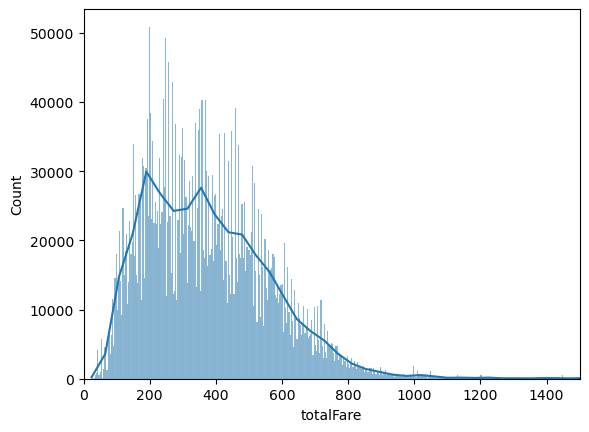

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразование PySpark DataFrame в Pandas DataFrame
pandas_df = df.sample(fraction=0.3, seed=42).toPandas()

# Создание гистограммы и KDE для признака 'actual_consumption' с использованием Pandas и Seaborn
sns.histplot(data=pandas_df, x='totalFare', kde=True)
plt.xlim(0, 1500)
plt.show()

# Визуализация параметра "Длительность полета"

<Axes: xlabel='travelDuration_inMinutes', ylabel='Count'>

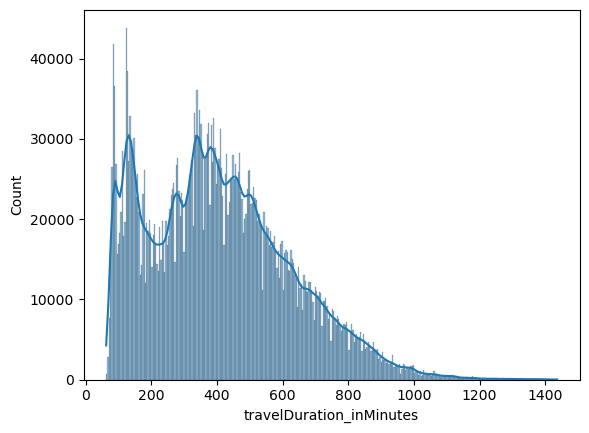

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразование PySpark DataFrame в Pandas DataFrame
pandas_df = df.sample(fraction=0.3, seed=42).toPandas()

# Создание гистограммы и KDE для признака 'actual_consumption' с использованием Pandas и Seaborn
sns.histplot(data=pandas_df, x='travelDuration_inMinutes', kde=True)
plt.show()

# Визуализация параметра расстояния полета

<Axes: xlabel='totalTravelDistance', ylabel='Count'>

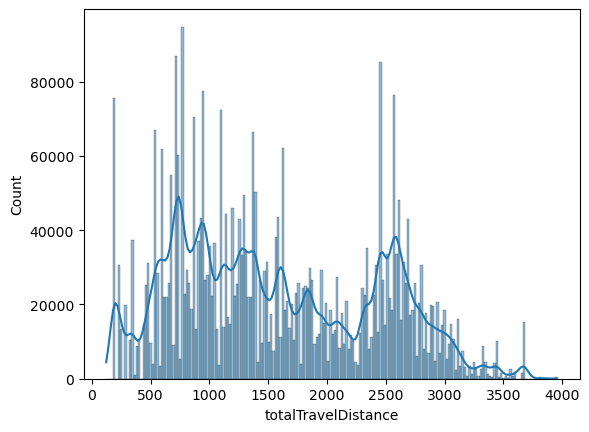

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразование PySpark DataFrame в Pandas DataFrame
pandas_df = df.sample(fraction=0.3, seed=42).toPandas()

# Создание гистограммы и KDE для признака 'actual_consumption' с использованием Pandas и Seaborn
sns.histplot(data=pandas_df, x='totalTravelDistance', kde=True)
plt.show()

# Визуализация параметра наличия возможности возврата билета

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='isRefundable'>

Text(0.5, 1.0, 'Distribution of isRefundable')

Text(0.5, 0, 'isRefundable')

Text(0, 0.5, 'Count')

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

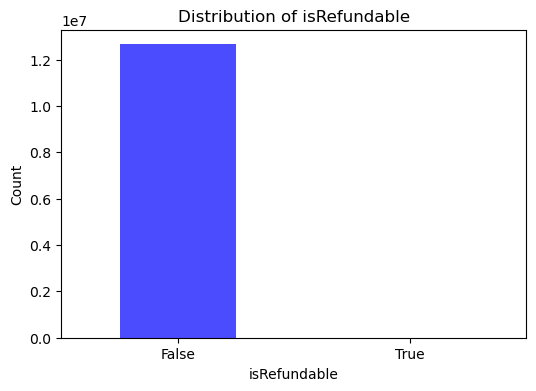

In [17]:
# Преобразовываем PySpark DataFrame в Pandas DataFrame для визуализации
pandas_df = df.select("isRefundable").toPandas()

# Строим гистограмму
plt.figure(figsize=(6, 4))
pandas_df['isRefundable'].value_counts().plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.title('Distribution of isRefundable')
plt.xlabel('isRefundable')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
plt.show()

In [18]:
# Подсчитываем количество значений 'True' и 'False'
count_values = df.groupBy("isRefundable").count()

# Выводим результат
count_values.show()

+------------+--------+
|isRefundable|   count|
+------------+--------+
|        true|     198|
|       false|12658279|
+------------+--------+



# Визуализация параметра isBasicEconomy

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='isBasicEconomy'>

Text(0.5, 1.0, 'Distribution of isBasicEconomy')

Text(0.5, 0, 'isBasicEconomy')

Text(0, 0.5, 'Count')

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

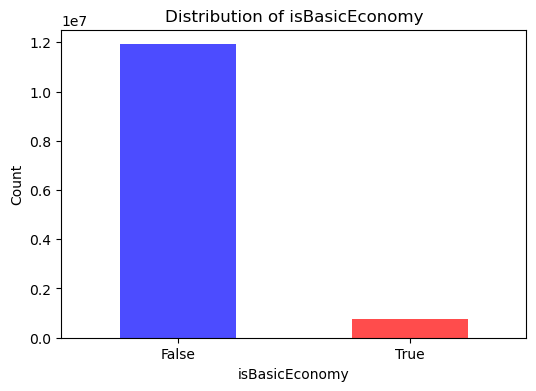

In [19]:
# Преобразовываем PySpark DataFrame в Pandas DataFrame для визуализации
pandas_df = df.select("isBasicEconomy").toPandas()

# Строим гистограмму
plt.figure(figsize=(6, 4))
pandas_df['isBasicEconomy'].value_counts().plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.title('Distribution of isBasicEconomy')
plt.xlabel('isBasicEconomy')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
plt.show()

# Визуализация параметра полета без пересадок

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='isNonStop'>

Text(0.5, 1.0, 'Distribution of isNonStop')

Text(0.5, 0, 'isNonStop')

Text(0, 0.5, 'Count')

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

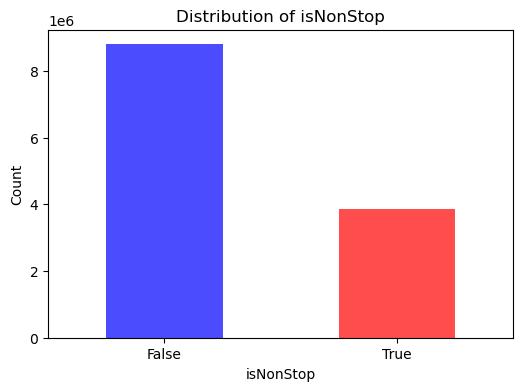

In [20]:
# Преобразовываем PySpark DataFrame в Pandas DataFrame для визуализации
pandas_df = df.select("isNonStop").toPandas()

# Строим гистограмму
plt.figure(figsize=(6, 4))
pandas_df['isNonStop'].value_counts().plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.title('Distribution of isNonStop')
plt.xlabel('isNonStop')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
plt.show()

# Визуализация параметра отложенных вылетов

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='elapsedDays_bool'>

Text(0.5, 1.0, 'Distribution of elapsedDays_bool')

Text(0.5, 0, 'elapsedDays_bool')

Text(0, 0.5, 'Count')

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

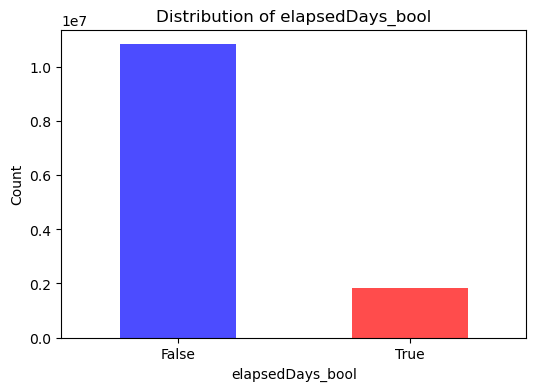

In [21]:
# Преобразовываем PySpark DataFrame в Pandas DataFrame для визуализации
pandas_df = df.select("elapsedDays_bool").toPandas()

# Строим гистограмму
plt.figure(figsize=(6, 4))
pandas_df['elapsedDays_bool'].value_counts().plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.title('Distribution of elapsedDays_bool')
plt.xlabel('elapsedDays_bool')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
plt.show()

# Корреляция признаков

In [ ]:
# Выбираем нужные колонки
selected_columns = ["isBasicEconomy", "isRefundable", "isNonStop", "baseFare", "totalFare", "seatsRemaining", "totalTravelDistance", "travelDuration_inMinutes", "elapsedDays_bool"]

# Подсчет корреляции
correlation_matrix = df.toPandas().corr()

# Построение хитмапа
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [22]:
df.show()

+--------------+------------+---------+--------+---------+--------------+-------------------+------------------------+----------------+
|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|travelDuration_inMinutes|elapsedDays_bool|
+--------------+------------+---------+--------+---------+--------------+-------------------+------------------------+----------------+
|         false|       false|     true|  217.67|    248.6|             9|                947|                     149|           false|
|         false|       false|     true|  217.67|    248.6|             4|                947|                     150|           false|
|         false|       false|     true|  217.67|    248.6|             9|                947|                     150|           false|
|         false|       false|     true|  217.67|    248.6|             8|                947|                     152|           false|
|         false|       false|     true|  217.67|

In [24]:
from pyspark.ml.feature import VectorAssembler, Bucketizer
from pyspark.ml.stat import Correlation

# Выбираем нужные колонки
selected_columns = ["isBasicEconomy", "isRefundable", "isNonStop", "baseFare", "totalFare", "seatsRemaining", "totalTravelDistance", "travelDuration_inMinutes", "elapsedDays_bool"]

# Создаем VectorAssembler для объединения признаков в один вектор
vector_assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(df)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Выводим матрицу корреляции
correlation_df = pd.DataFrame(correlation_array, columns=selected_columns)
correlation_df.corr()

,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration_inMinutes,elapsedDays_bool
isBasicEconomy,1.000000,-0.076226,0.320874,-0.712866,-0.709031,0.447851,-0.588918,-0.459714,-0.263144
isRefundable,-0.076226,1.000000,0.045740,-0.183048,-0.182223,-0.126616,-0.220350,-0.165372,-0.221349
isNonStop,0.320874,0.045740,1.000000,-0.696153,-0.709142,0.401769,-0.847580,-0.963041,-0.513510
baseFare,-0.712866,-0.183048,-0.696153,1.000000,0.999828,-0.491680,0.825381,0.748059,0.252724
totalFare,-0.709031,-0.182223,-0.709142,0.999828,1.000000,-0.494439,0.832424,0.759802,0.262475
seatsRemaining,0.447851,-0.126616,0.401769,-0.491680,-0.494439,1.000000,-0.549434,-0.526000,-0.351943
totalTravelDistance,-0.588918,-0.220350,-0.847580,0.825381,0.832424,-0.549434,1.000000,0.930038,0.459725
travelDuration_inMinutes,-0.459714,-0.165372,-0.963041,0.748059,0.759802,-0.526000,0.930038,1.000000,0.555332
elapsedDays_bool,-0.263144,-0.221349,-0.513510,0.252724,0.262475,-0.351943,0.459725,0.555332,1.000000


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

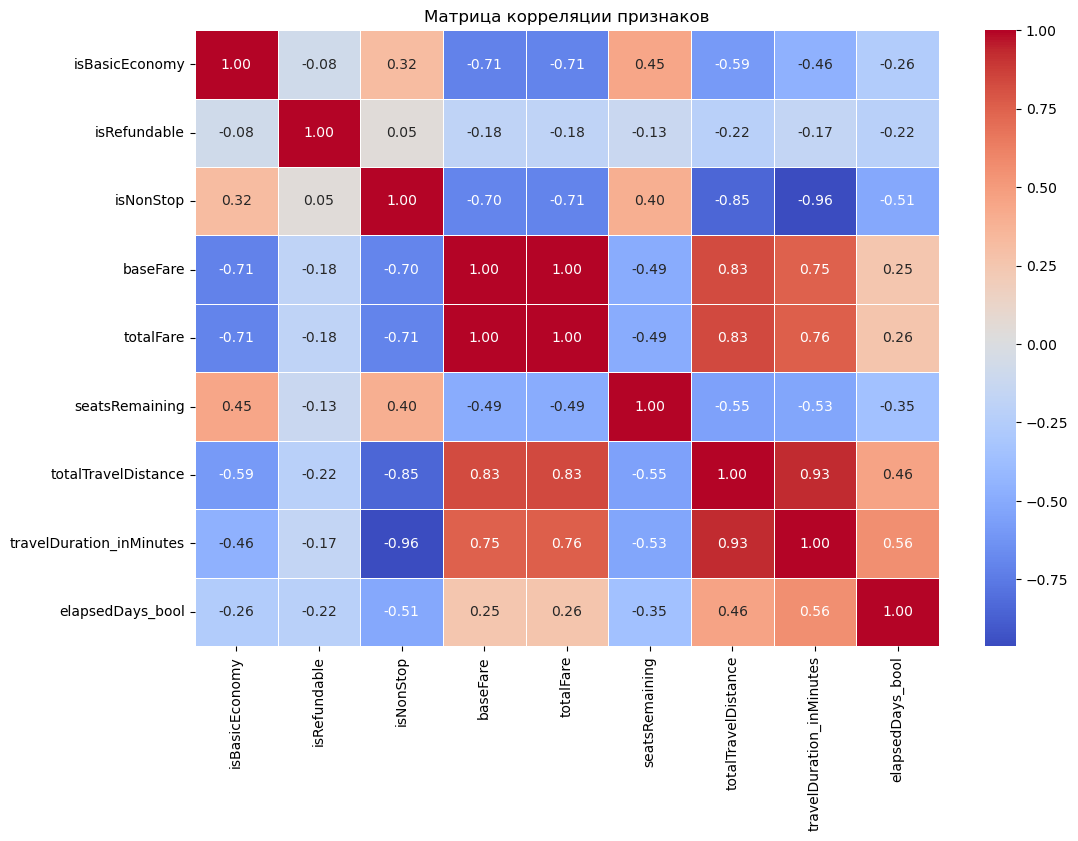

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()